<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d5_fixes/tutorials/W2D5_GenerativeModels/W2D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Introduction to GANs

**Week 2, Day 5: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Kai Xu, Seungwook Han, Akash Srivastava

__Content reviewers:__ Polina Turishcheva, Melvin Selim Atay, Hadi Vafaei, Deepak Raya, Charles J Edelson, Kelson Shilling-Scrivo

__Content editors:__ Charles J Edelson, Kelson Shilling-Scrivo, Spiros Chavlis

__Production editors:__ Arush Tagade, Spiros Chavlis

__Post-Production team:__ Gagana B, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---

## Tutorial Objectives

The goal of this tutorial is two-fold; first you will be introduced to GANs training, and you will be able to understand how GANs are connected to other generative models that we have been before. 

By the end of the first part of this tutorial you will be able to:
- Understand, at a high level, how GANs are implemented.
- Understand the training dynamics of GANs. 
- Know about a few failure modes of GAN training.
- Understand density ratio estimation using a binary classifier
- Understand the connection between GANs and other generative models.
- Implement a GAN.

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/dftym/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/dftym/download).

---
# Setup

In [2]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W2D5_T2','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

In [3]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
plt.rc('axes', unicode_minus=False)

In [5]:
# @title Plotting functions

ld_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00,
        -6.8569e-01, -1.4620e+00, -9.2639e-02, -1.4160e-01, -3.6734e-01,
        -1.0053e+00, -6.7353e-01, -2.2676e+00, -6.0812e-01, -1.0005e+00,
        -4.2908e-01, -5.1369e-01, -2.2579e-02, -1.8496e-01, -3.4798e-01,
        -7.3089e-01, -1.1962e+00, -1.6095e+00, -1.7558e-01, -3.3166e-01,
        -1.1445e+00, -2.4674e+00, -5.0600e-01, -2.0727e+00, -5.4371e-01,
        -8.0499e-01, -3.0521e+00, -3.6835e-02, -2.0485e-01, -4.6747e-01,
        -3.6399e-01, -2.6883e+00, -1.9348e-01, -3.1448e-01, -1.6332e-01,
        -3.2233e-02, -2.3336e-01, -2.6564e+00, -1.2841e+00, -1.3561e+00,
        -7.4717e-01, -2.7926e-01, -8.7849e-01, -3.3715e-02, -1.4933e-01,
        -2.7738e-01, -1.6899e+00, -1.5758e+00, -3.2608e-01, -6.5770e-01,
        -1.7136e+00, -5.8316e+00, -1.1988e+00, -8.3828e-01, -1.8033e+00,
        -2.3017e-01, -8.9936e-01, -1.1917e-01, -1.6659e-01, -2.7669e-01,
        -1.2955e+00, -1.2076e+00, -2.2793e-01, -1.0528e+00, -1.4894e+00,
        -5.7428e-01, -7.3208e-01, -9.5673e-01, -1.6617e+00, -3.9169e+00,
        -1.2182e-01, -3.8092e-01, -1.1924e+00, -2.4566e+00, -2.7350e+00,
        -2.8332e+00, -9.1506e-01, -6.7432e-02, -7.8965e-01, -2.0727e-01,
        -3.4615e-02, -2.8868e+00, -2.1218e+00, -1.2368e-03, -9.0038e-01,
        -5.3746e-01, -5.4080e-01, -3.1625e-01, -1.1786e+00, -2.2797e-01,
        -1.1498e+00, -1.3978e+00, -1.9515e+00, -1.1614e+00, -5.1456e-03,
        -1.9316e-01, -1.3849e+00, -9.2799e-01, -1.1649e-01, -2.3837e-01]


def plotting_ld(ld, true=ld_true):
  """
  Helper function to plot discriminator loss from user 
  implementation and oracle implementation

  Args:
    ld: list
      Log of loss from user implementation
    true: list
      Log of loss from oracle implementation

  Returns: 
    Nothing
  """
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.plot([-6, 1], [-6, 1], label="Ground Truth")
  ax.scatter(true, ld, marker="x",
             label="Your implementation")
  ax.set_xlabel("Loss from oracle implementation")
  ax.set_ylabel("Loss from your implementation")
  ax.legend()
  ax.set_title("Discriminator Loss")


lg_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00]


def plotting_lg(lg, true=lg_true):
  """
  Helper function to plot generator loss from user 
  implementation and oracle implementation

  Args:
    ld: list
      Log of loss from user implementation
    true: list
      Log of loss from oracle implementation

  Returns: 
    Nothing
  """
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.plot([-6, 1], [-6, 1], label="Ground Truth")
  ax.scatter(true, lg, marker="x",
             label="Your implementation")
  ax.set_xlabel("Loss from oracle implementation")
  ax.set_ylabel("Loss from your implementation")
  ax.legend()
  ax.set_title("Generator loss")

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: How to train GANs

*Time estimate: ~15mins*

In [9]:
# @title Video 1: Generative Adversarial Networks
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1o64y1i7xA", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"FmUbll93kms", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Generative Adversarial Networks')

display(out)

GANs consist two networks: A critic or discriminator (`disc`) and a generator (`gen`) that are trained by alternating between the following two steps:
- In step 1, we update the parameters (`disc.params`) of the discriminator by backpropagating through the discriminator loss (BCE loss) `disc.loss`.
- In step 2, we update the parameters (`gen.params`) of the generator by backpropagating through the generator loss, `gen.loss` (-1 * BCE loss).

We will now implement a simple GAN training loop!

## Coding Exercise 1: The GAN training loop

To get you started we have implemented a simple GAN in pseudocode. All you have to do is to implement the training loop.

__Your goal__ is to arrange the functions given below in the correct order in the `train_gan_iter` function
- `disc.loss(x_real, x_fake)`: Discriminator loss
- `disc.classify(x)`: Classify `x` as real or fake
- `gen.loss(x_fake, disc_fn)`: Generator loss
- `disc_fn(x)` is a function to check `x` is real or fake.
- `gen.sample(num_samples)`: Generate samples from the generator
- `backprop(loss, model)`: Compute gradient of `loss` wrt `model`
- `model` is either `disc` or `gen`

We have already taken care of most of these functions. So you only have to figure out the placement of `disc.loss` and `gen.loss` functions.

__We highly recommend studying `train_gan_iter` function to understand how the GAN training loop is structured.__ 

In [10]:
# @markdown *Execute this cell to enable helper functions*

def get_data():
  return "get_data"


class Disc:
  """
  Disciminator class
  """

  def loss(self, x_real, x_fake):
    assert x_real == "get_data" and x_fake == "gen.sample", "Inputs to disc.loss is wrong"

  def classify(self, x):
    return "disc.classify"


class Gen:
  """
  Generator class
  """

  def loss(self, x_fake, disc_fn):
    assert x_fake == "gen.sample" and disc_fn(None) == "disc.classify", "Inputs to gen.loss is wrong"

  def sample(self, num_samples):
    return "gen.sample"


def backprop(loss, model):
  pass


def update(model, grad):
  pass

In [11]:
def train_gan_iter(data, disc, gen):
  """
  Update the discriminator (`disc`) and the generator (`gen`) using `data`

  Args:
    data: ndarray
      An array of shape (N,) that contains the data
    disc: Disc
      The discriminator
    gen: Gen
      The generator

  Returns:
    None
  """
  #################################################
  # Intructions for students:                     #
  # Fill out ... in the function and remove below #
  #################################################

  # Number of samples in the data batch
  num_samples = 200

  # The data is the real samples
  x_real = data

  ## Discriminator training

  # Ask the generator to generate some fake samples
  x_fake = gen.sample(num_samples)

  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: Write code to compute disc_loss")
  #################################################
  # Compute the discriminator loss
  disc_loss = ...

  # Compute the gradient for discriminator
  disc_grad = backprop(disc_loss, disc)

  # Update the discriminator
  update(disc, disc_grad)

  ## Generator training

  # Ask the generator to generate some fake samples
  x_fake = gen.sample(num_samples)

  #################################################
  ## TODO for students: details of what they should do ##
  # Fill out function and remove
  raise NotImplementedError("Student exercise: Write code to compute gen_loss")
  #################################################
  # Compute the generator loss
  gen_loss = ...

  # Compute the gradient for generator
  gen_grad = backprop(gen_loss, gen)

  # Update the generator
  update(gen, gen_grad)

  print("Your implementation passes the check!")

  return None


# Add event to airtable
atform.add_event('Coding Exercise 1: The GAN training loop')

data = get_data()
disc = Disc()
gen = Gen()
## Uncomment below to check your function
# train_gan_iter(data, disc, gen)

In [12]:
# to_remove solution
def train_gan_iter(data, disc, gen):
  """
  Update the discriminator (`disc`) and the generator (`gen`) using `data`

  Args:
    data: ndarray
      An array of shape (N,) that contains the data
    disc: Disc
      The discriminator
    gen: Gen
      The generator

  Returns:
    None
  """

  # Number of samples in the data batch
  num_samples = 200

  # The data is the real samples
  x_real = data

  ## Discriminator training

  # Ask the generator to generate some fake samples
  x_fake = gen.sample(num_samples)

  # Compute the discriminator loss
  disc_loss = disc.loss(x_real, x_fake)

  # Compute the gradient for discriminator
  disc_grad = backprop(disc_loss, disc)

  # Update the discriminator
  update(disc, disc_grad)

  ## Generator training

  # Ask the generator to generate some fake samples
  x_fake = gen.sample(num_samples)

  # Compute the generator loss
  gen_loss = gen.loss(x_fake, disc.classify)

  # Compute the gradient for generator
  gen_grad = backprop(gen_loss, gen)

  # Update the generator
  update(gen, gen_grad)

  print("Your implementation passes the check!")

  return None


# Add event to airtable
atform.add_event('Coding Exercise 1: The GAN training loop')

data = get_data()
disc = Disc()
gen = Gen()
## Uncomment below to check your function
train_gan_iter(data, disc, gen)

Your implementation passes the check!


---
# Section 2: GAN Training Objective

*Time estimate: ~20mins*

The training objective of GANs consists of the losses for generators and discriminators respectively. In this section we will be implementing these objectives.

In [13]:
# @title Video 2: Principles of GANs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1bo4y1U7YT", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"U_4z5-hX1Kg", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: Principles of GANs')

display(out)

## Section 2.1:  Discriminator Loss

The critic or the discriminator in a vanilla GAN is trained as a binary classifier using the BCE (Binary Cross Entropy) criteria. In this section, we will implement the training objective for the discriminator. 

\begin{equation}
\text{BCE}_\omega = \mathbb{E}_{x \sim p}[\log(\sigma(D_\omega(x)))] + \mathbb{E}_{x \sim q}[\log(1 - \sigma(D_\omega(x)))]
\end{equation}

Here, $p$ is the data distribution and $q$ is the generator distribution. $D_\omega$ is the logit, which represents $\log \frac{p}{q}$. $\sigma$ is the sigmoid function and therfore, $\sigma(D_\omega)$ represents $\frac{p}{p+q}$.

### Coding Exercise 2.1: Implement Discriminator Loss

To get you started we have implemented a simple GAN in pseudocode and partially implemented the discriminator training objective.

**Your goal** is to complete the missing part in the training objective of the discriminator in the function `loss_disc`.

`loss_disc` also allows you evaluate the loss function on some random samples.
If your implementation is correct, you will see a plot where the loss values from your implementation will match the ground truth loss values.

In practice, given $N$ samples, we estimate BCE as

\begin{equation}
\text{BCE}_\omega = -\frac{1}{N} \sum_{i=1}^N y_i \log(\sigma(D_\omega(x_i)) + (1-y_i) \log(1-\sigma(D_\omega(x_i))).
\end{equation}

Here, $y$ is the label. $y=1$ when $x \sim p$ (real data) and $y=0$ when $x \sim q$ (i.e., fake data).

Please note, `disc.classify` = $\sigma(D_\omega)$ in `loss_disc`.

In [14]:
# @markdown *Execute this cell to enable helper functions*

def get_data(num_samples=100, seed=0):
  set_seed(seed)
  return torch.randn([num_samples, 1])


class DummyGen:
  """
  Dummy Generator
  """
  def sample(self, num_samples=100, seed=1):
    set_seed(seed)
    return torch.randn([num_samples, 1]) + 2


class DummyDisc:
  """
  Dummy Discriminator
  """
  def classify(self, x, seed=0):
    set_seed(seed)
    return torch.rand([x.shape[0], ])

In [15]:
def loss_disc(disc, x_real, x_fake):
  """
  Compute the discriminator loss for `x_real` and `x_fake` given `disc`

  Args:
    disc: Disc
      The discriminator
    x_real: ndarray
      An array of shape (N,) that contains the real samples
    x_fake: ndarray
      An array of shape (N,) that contains the fake samples

  Returns:
    ndarray with log of the discriminator loss
  """

  label_real = 1
  #################################################
  # TODO for students: Loss for real data
  raise NotImplementedError("Student exercise: Implement loss for real samples")
  #################################################
  loss_real = label_real * ...

  label_fake = 0
  #################################################
  # TODO for students: Loss for fake data
  raise NotImplementedError("Student exercise: Implement loss for fake samples")
  #################################################
  loss_fake = ... * torch.log(1 - disc.classify(x_fake))


  return torch.cat([loss_real, loss_fake])


# Add event to airtable
atform.add_event('Coding Exercise 2.1: Implement Discriminator Loss')

disc = DummyDisc()
gen = DummyGen()

x_real = get_data()
x_fake = gen.sample()

## Uncomment to check your function
# ld = loss_disc(disc, x_real, x_fake)
# plotting_ld(ld)

Random seed 0 has been set.
Random seed 1 has been set.


Random seed 0 has been set.
Random seed 1 has been set.
Random seed 0 has been set.
Random seed 0 has been set.


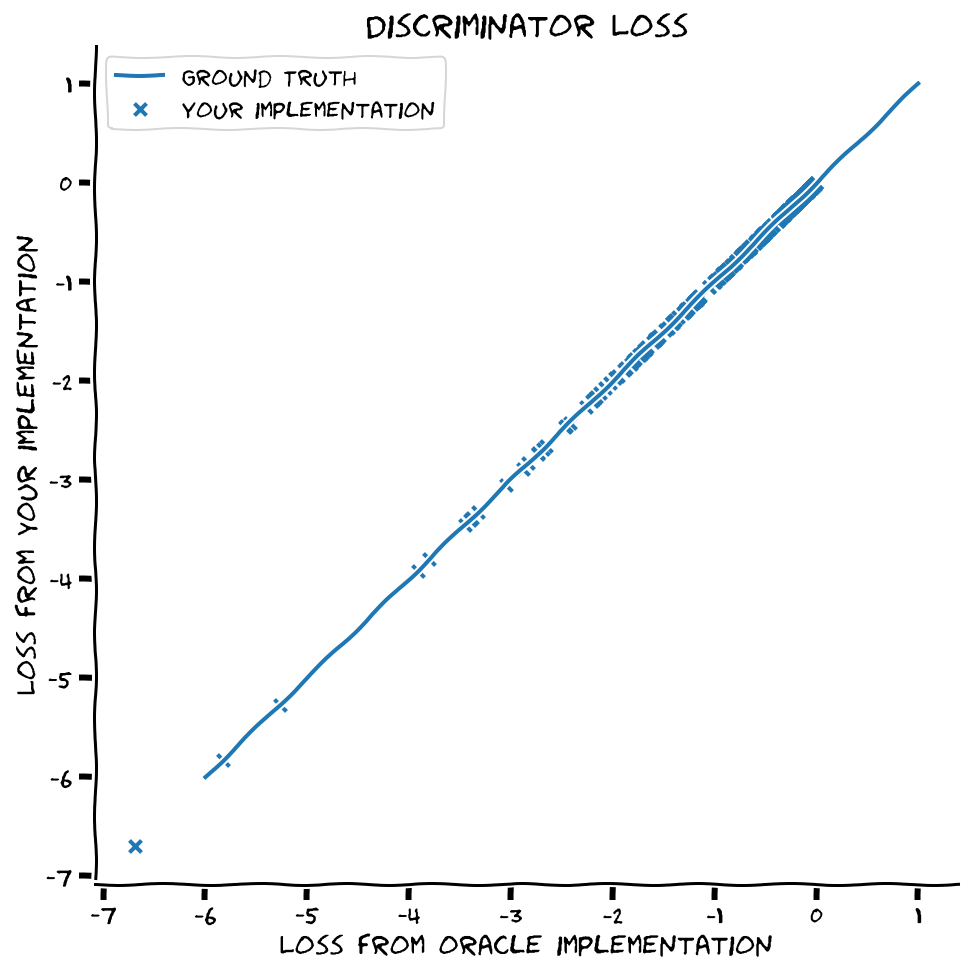

In [16]:
# to_remove solution
def loss_disc(disc, x_real, x_fake):
  """
  Compute the discriminator loss for `x_real` and `x_fake` given `disc`

  Args:
    disc: Disc
      The discriminator
    x_real: ndarray
      An array of shape (N,) that contains the real samples
    x_fake: ndarray
      An array of shape (N,) that contains the fake samples

  Returns:
    ndarray with log of the discriminator loss
  """

  # Loss for real data
  label_real = 1
  loss_real = label_real * torch.log(disc.classify(x_real))

  # Loss for fake data
  label_fake = 0
  loss_fake = (1 - label_fake) * torch.log(1 - disc.classify(x_fake))

  return torch.cat([loss_real, loss_fake])


# Add event to airtable
atform.add_event('Coding Exercise 2.1: Implement Discriminator Loss')

disc = DummyDisc()
gen = DummyGen()

x_real = get_data()
x_fake = gen.sample()

## Uncomment to check your function
ld = loss_disc(disc, x_real, x_fake)
with plt.xkcd():
  plotting_ld(ld)

**A note on numerical stability**

It is common that functions like $\log$ throw a numerical error.
For $\log$, it happens when $x$ in $\log(x)$ is very close to 0.
The most common practice is to always add some very small value $\epsilon$ to $x$, i.e. use $\log(x + \epsilon)$ instead.
Most built-in functions in modern DL frameworks like TensorFlow or PyTorch handle such things in their built-in loss already, e.g., `torch.nn.BCE`, which is equivalent to the loss you implemented above.

## Section 2.3:  The generator loss

Now that we have a trained critic, lets see how to train the generator using it.

### Coding Exercise 2.3: The generator loss

We will now implement the generator loss function and evaluate it on some fixed points.

**Your goal** is to complete the implementation of the function `loss_gen` using the optimal critic from above.

Upon correct implementation, you shall see a plot where the loss values from generator samples align with the "Correct" values.

**HINT:** You simply need to change the labels. 

In [17]:
def loss_gen(disc, x_fake):
  """
  Compute the generator loss for `x_fake` given `disc`

  Args:
    disc: Disc
      The generator
    x_fake: ndarray
      An array of shape (N,) that contains the fake samples

  Returns:
    loss_fake: ndarray
      The generator loss
  """

  #################################################
  # TODO for students: Loss for fake data
  raise NotImplementedError("Student exercise: Implement loss for fake data")
  #################################################
  label_fake = ...
  loss_fake = label_fake * ...

  return loss_fake


# Add event to airtable
atform.add_event('Coding Exercise 2.3: The generator loss')

disc = DummyDisc()
gen = DummyGen()

x_fake = gen.sample()
## Uncomment below to check your function
# lg = loss_gen(disc, x_fake)
# plotting_lg(lg)

Random seed 1 has been set.


Random seed 1 has been set.
Random seed 0 has been set.


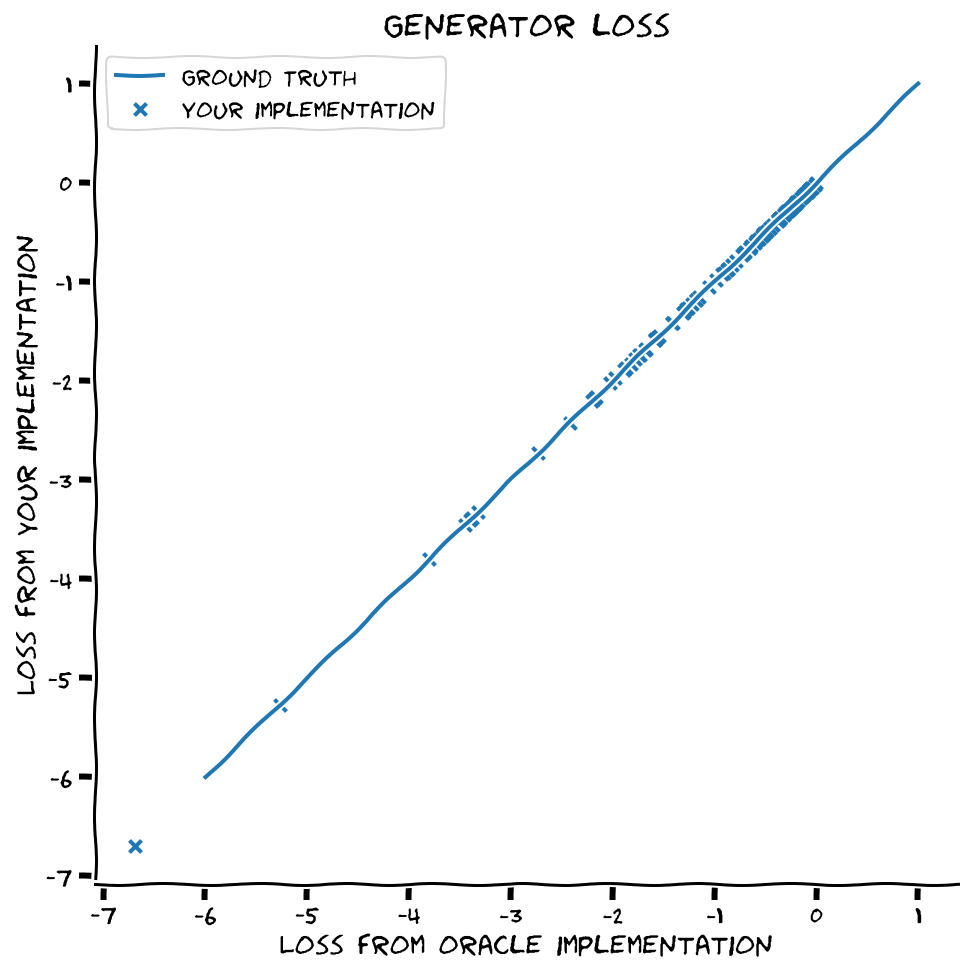

In [18]:
# to_remove solution
def loss_gen(disc, x_fake):
  """
  Compute the generator loss for `x_fake` given `disc`

  Args:
    disc: Disc
      The generator
    x_fake: ndarray
      An array of shape (N,) that contains the fake samples

  Returns:
    loss_fake: ndarray
      The generator loss
  """

  # Loss for fake data
  label_fake = 1
  loss_fake = label_fake * torch.log(disc.classify(x_fake))

  return loss_fake


# Add event to airtable
atform.add_event('Coding Exercise 2.3: The generator loss')

disc = DummyDisc()
gen = DummyGen()

x_fake = gen.sample()
## Uncomment below to check your function
lg = loss_gen(disc, x_fake)
with plt.xkcd():
  plotting_lg(lg)

**Did you notice?**

The loss you implemented for generator is essentially the part for real data in `loss_disc`, i.e., it is saying, "*the data I am feeding to you is real and not fake*".

---
# Section 3: The difficulty of GAN training.

*Time estimate: ~10mins*

In this section we will develop an intuition for the training dynamics of GANs.

## Interactive Demo 2: Failure modes of GAN training

GAN training is notoriously difficult because 
it is very sensitive to hyper-parameters such as learning rate and model architecture. To help you develop a sense of this here is a very simple GAN training demo that we have borrowed from [Andrej Karpathy's website](https://cs.stanford.edu/people/karpathy/gan/).  

The generator $G$, pictured in red, takes inputs sampled from a uniform distribution, $z$. It attempts to transform these to match a data distribution, shown below in blue. Meanwhile, the discriminator $D$ attempts to determine whether a sample is from the data distribution or the generating distribution. In the demo, the green curve represents the output of the discriminator. Its value is high where the discriminator is more confident that a sample with that value is drawn from the data distribution.

Even though the GAN in this demo is very simple and operates in either 1D or 2D spaces, it is however very sensitive to the learning rate. Try it for yourself!

In [19]:
# @title Video 3: GAN generator Learning Idea
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1aL411J7SE", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Iqqz2_USUGs", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: GAN generator Learning Idea')

display(out)

In [20]:
# @title GAN training demo
# @markdown Make sure you execute this cell to enable the widget!

from IPython.display import IFrame
IFrame(src='https://xukai92.github.io/gan_demo/index.html', width=900, height=600)

## Think! 2: What makes GANs hard to train?

You have played with the demo and it's time to think about a few questions

1. Which target is more stable to train, 1D or 2D?
2. If you keep increasing the learning rate, what happens? Does it happen in both the cases, i.e., 1D/2D targets?
3. Can you think of some drawbacks of using small learning rates?

In [21]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [22]:
# to_remove explanation

"""
1. 2D as it is simply a more difficult distribution to model compared to the
  unimodal 1D example.
2. The training becomes unstable and eventually diverges. Yes.
3. Training is too slow and takes longer to converge.

In general, when training a GAN, we need to ensure a certain balance between
the critic and generator training. As such, tuning the learning rate
is crucial for succesfully training GANs.
""";

In [23]:
# @title Video 4: GAN Failure Models
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV17M4y1L7w9", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"fmU2UM_QzLo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 4: GAN Failure Models')

display(out)

---
# Section 4: GAN training in action!

*Time estimate: ~4mins*

In this section we will be playing with a complete implementation of GAN.

## Interactive Demo 4: GAN training in action


In [24]:
# @title GanLab
from IPython.display import HTML
HTML('<iframe width="1500" height="660" src="https://poloclub.github.io/ganlab/" allowfullscreen></iframe>')

---
# Summary

Through this tutorial, we have learned

- How to implement the training loop of GANs.
- Developed an intuition about the training dynamics of GANs.
- How to implement the training objectives for the generator and discriminator of GANs.
- How are GANs connected to density ratio estimation.

Next tutorial will cover conditional GANs and ethical issues of DL.

In [25]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )